# Denoising





Pour ce projet vous avez :

Pour le train 
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers. 

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires. 

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai. 

L'objectif est d'estimer à partir du signal bruité le signal de voix. 

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB. 

Vous pouvez au choix travailler 
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 09 et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  : 
   - cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
   - les apporches TAS NEt : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la fonction de perte utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones. 

Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.  


In [35]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wavfile
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile

# Visualisation 

In [36]:
# Import audio .wav file with scipy.io.wavfile.read

rate, data = scipy.io.wavfile.read('denoising/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav')

# Listen to the audio file with IPython.display.Audio

ipd.Audio(data, rate=rate)


## Data

In [89]:
def normalize_waveform(waveform):
    # Normalize the waveform in the range [-1, 1]
    return waveform / np.max(np.abs(waveform))

class AudioDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir):
        self.noisy_files = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.wav')]
        self.clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.wav')]
        assert len(self.noisy_files) == len(self.clean_files), "Mismatch in dataset size"

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        # Use scipy.io.wavfile.read to read the wav file
        noisy_rate, noisy_waveform = wavfile.read(self.noisy_files[idx])
        clean_rate, clean_waveform = wavfile.read(self.clean_files[idx])

        # convert clean_rate which is in int16 to float32
        clean_waveform = clean_waveform.astype(np.float32)
        
        # Apply normalization directly here
        noisy_waveform = normalize_waveform(noisy_waveform)
        clean_waveform = normalize_waveform(clean_waveform)

        return noisy_waveform, clean_waveform

In [90]:
# Training loop
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Validation loop
def validate(dataloader, model, loss_fn):
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

In [106]:
train_dataset = AudioDenoisingDataset('voice_origin/train/', 'denoising/train/')
test_dataset = AudioDenoisingDataset('voice_origin/test/', 'denoising/test/')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


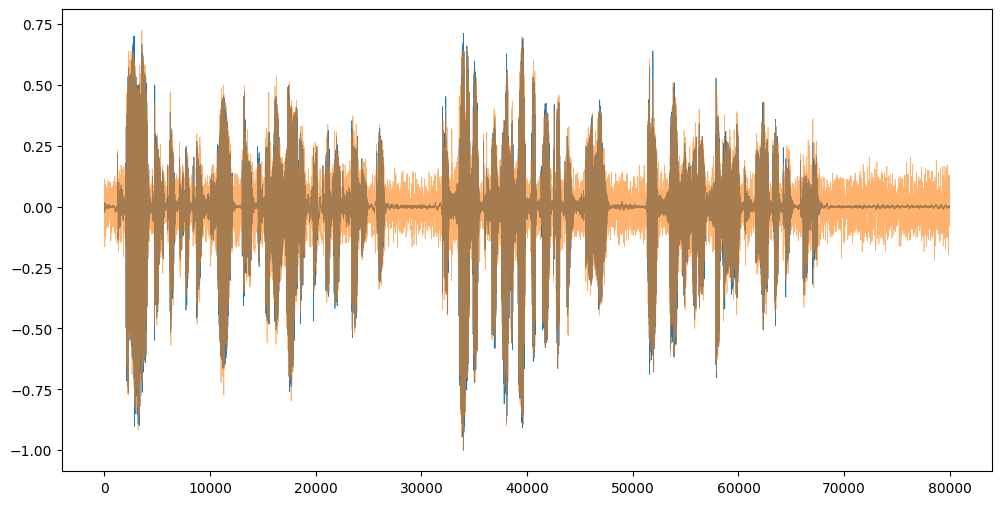

In [107]:
plt.figure(figsize=(12, 6))
#get first item in train_loader
noisy_waveform, waveform_denoised = next(iter(test_loader))
plt.plot(noisy_waveform[0], linewidth=0.5, alpha=1)
plt.plot(waveform_denoised[0], linewidth=0.5, alpha=0.6)
plt.show()

## Model

In [ ]:
# Deep learning model
import torch
import torch.nn as nn

class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(32, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.upsample(x)
        return x

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchaudio import transforms
from torch import nn, optim


# Parameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Data preparation
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = DenoisingNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)



# Run the training and validation
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    validate(val_loader, model, loss_fn)
    scheduler.step()  # Adjust the learning rate
print("Done!")


AttributeError: module 'torchaudio.transforms' has no attribute 'Compose'